# SETUP

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### 예제 1 : 다수결 방법
- - -

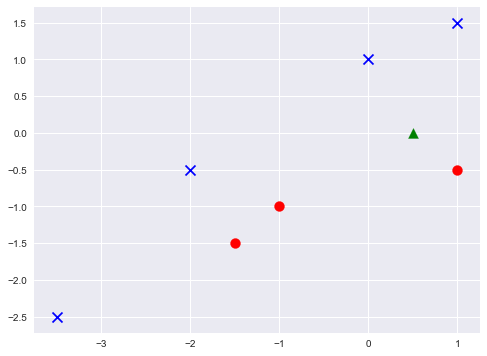

In [12]:
X = np.array([[-1, -1], [-1.5, -1.5], [1, -0.5], [-3.5, -2.5], [0, 1], [1, 1.5], [-2, -0.5]])
y = np.array([1, 1, 1, 2, 2, 2, 2])

plt.figure(figsize=(8, 6))
plt.scatter(X[y==1,0], X[y==1,1], s=100, marker='o', color='r')
plt.scatter(X[y==2,0], X[y==2,1], s=100, marker='x', color='b')

x_new = [0.5, 0]

plt.scatter(x_new[0], x_new[1], s=100, marker='^', color='g')
plt.show()

In [13]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [57]:
model1 = LogisticRegression(random_state=1)
model2 = QuadraticDiscriminantAnalysis()
model3 = GaussianNB()
ensemble = VotingClassifier(estimators=[('lr', model1), ('qda', model2), ('gnb', model3)], \
                            voting='soft', weights=[1, 1, 2])
probas = [c.fit(X, y).predict_proba([x_new]) for c in (model1, model2, model3, ensemble)]
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]

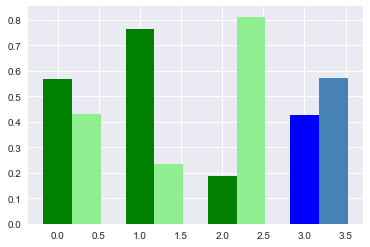

In [66]:
ind = np.arange(4)
width = 0.35 
p1 = plt.bar(ind, np.hstack([class1_1[:-1], [0]]), width, color='green')
p2 = plt.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width, color='lightgreen')
p3 = plt.bar(ind, [0, 0, 0, class1_1[-1]], width, color='blue')
p4 = plt.bar(ind + width, [0, 0, 0, class2_1[-1]], width, color='steelblue')
plt.show()

### 예제 2 : 배깅
- - -

In [67]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

In [71]:
iris = load_iris()
X, y = iris.data[:, [0, 2]], iris.target

In [73]:
model1 = DecisionTreeClassifier().fit(X, y)
model2 = BaggingClassifier(DecisionTreeClassifier(), bootstrap_features=True, random_state=0).fit(X, y)

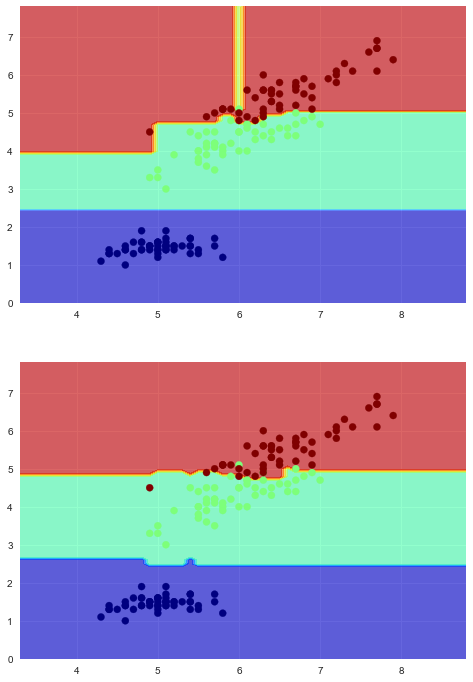

In [78]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

plt.figure(figsize=(8, 12))

plt.subplot(211)
Z1 = model1.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z1, alpha=0.6, cmap=mpl.cm.jet)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1, s=50, cmap=mpl.cm.jet)

plt.subplot(212)
Z2 = model2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z2, alpha=0.6, cmap=mpl.cm.jet)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1, s=50, cmap=mpl.cm.jet)

### 예제 3 : 랜덤 포레스트
- - -

In [1]:
from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
iris = load_iris()

n_classes = 3
n_estimators = 30
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02
seed = 13

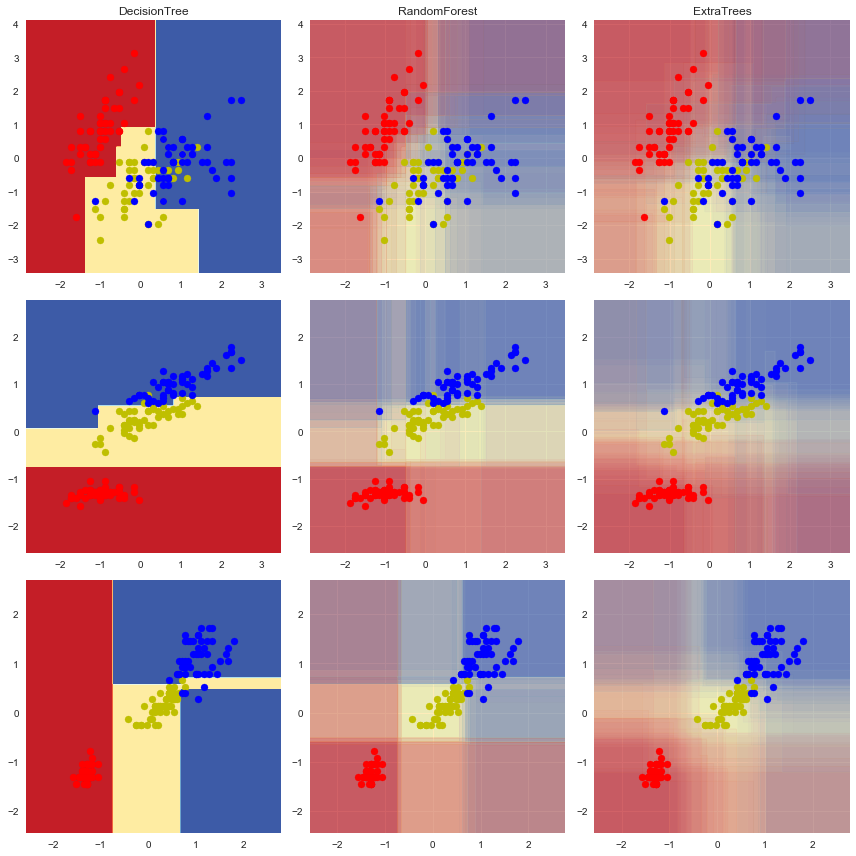

In [5]:
models = [DecisionTreeClassifier(max_depth=4),
          RandomForestClassifier(max_depth=4, n_estimators=n_estimators),
          ExtraTreesClassifier(max_depth=4, n_estimators=n_estimators)]

plot_idx = 1
plt.figure(figsize=(12, 12))
for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        X = iris.data[:, pair]
        y = iris.target

        idx = np.arange(X.shape[0])
        np.random.seed(seed)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        clf = clone(model)
        clf = model.fit(X, y)

        plt.subplot(3, 3, plot_idx)
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        if plot_idx <= len(models):
            plt.title(model_title)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        for i, c in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c,
                        label=iris.target_names[i], cmap=cmap)

        plot_idx += 1

plt.tight_layout()
plt.show()

##### feautre importance

In [6]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=10, n_informative=3, n_redundant=0, n_repeated=0,
                           n_classes=2, random_state=0, shuffle=False)

In [8]:
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [9]:
forest.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [11]:
importances = forest.feature_importances_
importances

array([0.17763201, 0.29590176, 0.20835127, 0.04712087, 0.04461413,
       0.04391181, 0.04630262, 0.04557492, 0.04601349, 0.04457711])

In [36]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

In [28]:
indices = np.argsort(importances)[::-1]
indices

array([1, 2, 0, 3, 6, 8, 7, 4, 9, 5])

In [34]:
for i in range(X.shape[1]):
    print("%d. feature %d (%f)" % (i + 1, indices[i], importances[indices[i]]))

1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


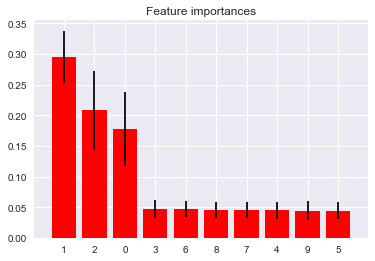

In [37]:
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()